# Import

In [1]:
import glob
#import cupy as cp
import os
import gc
import sys
import time
import yaml
import argparse
import logging
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
#from tqdm import tqdm
from torch.utils.data import DataLoader
print(torch.__version__)
import matplotlib.pyplot as plt
from numba import njit
%matplotlib inline
from janest_model import CustomDataset, train_model, autoencoder2, ResNetModel, SmoothBCEwLogits, utility_score_bincount, train_model_unity
from janest_model import TransformerModel
from utils import PurgedGroupTimeSeriesSplit, get_args

1.7.1+cu110


In [2]:
#%%writefile test.py
#print('hello world!')

## Parameter setting

In [3]:
TRAINING = False
USE_FINETUNE = True     
FOLDS = 5
GROUP_GAP = 20
SEED = 66
INPUTPATH = '../../input'
NUM_EPOCH = 500
BATCH_SIZE = 32768
PATIANCE = 15
LR = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
MDL_PATH  = '../models'
MDL_NAME = 'autoencoder'
VER = 'early_stopping'
THRESHOLD = 0.5

cuda


## Import Data 

In [10]:
%%time
train = pd.read_parquet(f'{INPUTPATH}/train.parquet')
train = train.query('date > 85').reset_index(drop = True) 
print(train.shape)
train.fillna(train.mean(),inplace=True)
train = train.query('weight > 0').reset_index(drop = True)
train['action'] =  \
(  (train['resp_1'] > 0.00001 ) & \
   (train['resp_2'] > 0.00001 ) & \
   (train['resp_3'] > 0.00001 ) & \
   (train['resp_4'] > 0.00001 ) & \
   (train['resp'] > 0.00001 )   ).astype('int')

features = [c for c in train.columns if 'feature' in c]

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

X = train[features].values
y = np.stack([(train[c] > 0.000001).astype('int') for c in resp_cols]).T
f_mean = np.mean(train[features[1:]].values,axis=0)

#f_mean = np.load( f'{INPUTPATH}/f_mean.npy')
date = np.load( f'{INPUTPATH}/date.npy')
weight = np.load( f'{INPUTPATH}/weight.npy' )
resp = np.load( f'{INPUTPATH}/resp.npy')
test_df = pd.read_csv(f'{INPUTPATH}/example_test.csv')
pred_df  = pd.read_csv(f'{INPUTPATH}/example_sample_submission.csv')

(1571415, 139)
CPU times: user 10.3 s, sys: 4.73 s, total: 15 s
Wall time: 3.87 s


# Features

In [11]:
print(X.shape[-1])
print(y.shape[-1])

130
5


In [12]:
class autoencoder(nn.Module):
    '''
    >> model = 
        autoencoder(input_size = X.shape[-1], output_size = y.shape[-1],\
        noise = 0.1).to(DEVICE)
    '''
    def __init__(self, **kwargs):
        super(autoencoder, self).__init__()
        input_size = kwargs['input_size']
        output_size = kwargs['output_size']
        noise = kwargs['noise']
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_size),
            #GaussianNoise(noise),
            nn.Linear(input_size, 640),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(640, input_size)
        )
        self.hidden = nn.Linear(input_size, 320)
        self.bat = nn.BatchNorm1d(320)
        self.drop = nn.Dropout(0.2)
        self.hidden2 = nn.Linear(320, output_size)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.hidden(x)
        x = self.bat(x)
        x = self.drop(x)
        x = self.hidden2(x)
        x = self.act(x)
        return x

# Trainning

## Data Split

In [13]:
if not TRAINING:   
    gkf =  PurgedGroupTimeSeriesSplit(n_splits = FOLDS,  group_gap = GROUP_GAP)
    for fold, (tr, vl) in enumerate(gkf.split(y, y, date)):
        pass

## Autoencoder

### autoencoder_early_stopping/autoencoder_254.pth

In [14]:
model = autoencoder(input_size = X.shape[-1], output_size = y.shape[-1], noise=0.1).to(DEVICE)

In [15]:
model

autoencoder(
  (encoder): Sequential(
    (0): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=130, out_features=640, bias=True)
    (2): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=640, out_features=130, bias=True)
  )
  (hidden): Linear(in_features=130, out_features=320, bias=True)
  (bat): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=320, out_features=5, bias=True)
  (act): Sigmoid()
)

In [16]:
model_list  = glob.glob(f'{MDL_PATH}/{MDL_NAME}_{VER}/*.pth')
print(model_list)

['../models/autoencoder_early_stopping/autoencoder_254.pth']


In [17]:
THRESHOLD=0.5

In [18]:
gkf =  PurgedGroupTimeSeriesSplit(n_splits = FOLDS,  group_gap = GROUP_GAP)
for fold, (tr, vl) in enumerate(gkf.split(y,y, date)):
    X_tr, X_val = X[tr], X[vl]
    y_tr, y_val = y[tr], y[vl]
    trn_dat = CustomDataset(X_tr, y_tr)
    val_dat = CustomDataset(X_val, y_val)
    trn_loader = DataLoader(trn_dat , batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dat , batch_size=BATCH_SIZE, shuffle=False)

    preds = []   

    for i, data in tqdm(enumerate(val_loader)):
        x = data['x'].to(DEVICE)
        outputs = np.zeros((len(x), 5))
        with torch.no_grad():
            for mdl in model_list:

                model.eval()
                outputs += model(x).sigmoid().detach().cpu().numpy()/len(model_list)
            preds.append(outputs)

    pred_all  = np.concatenate(preds)


#             action = np.where(pred_all[:,0] >= THRESHOLD, 1, 0).astype(int).copy()
    action = np.where(np.mean(pred_all, axis=1)> THRESHOLD, 1, 0).astype(int).copy()
    if np.sum(action)>0:
        date_vl = date[vl].copy()
        weight_vl = weight[vl].copy()
        resp_vl = resp[vl].copy()
        action_ans_vl = np.where(y[vl,0]> THRESHOLD, 1, 0).astype(int).copy()
        cv_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action)
        max_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action_ans_vl )
        print('CV score is {}, Max score is {}, return ration is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
#         logger.info('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
    else:
        raise ZeroDivisionError

|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is 10786.6377949325, return ration is -0.0 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is 14589.84571618053, return ration is -0.0 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is 13971.761285746, return ration is -0.0 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is 13014.414197417686, return ration is -0.0 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is 14679.412120092362, return ration is -0.0 


### autoencoder_ho_base_007/autoencoder_fold_ho_19.pth

In [26]:
f_mean = np.load( f'{INPUTPATH}/f_mean_03.npy')
X = np.load( f'{INPUTPATH}/X_03.npy')
y = np.load( f'{INPUTPATH}/y_03.npy')
date = np.load( f'{INPUTPATH}/date_03.npy')
weight = np.load( f'{INPUTPATH}/weight_03.npy' )
resp = np.load( f'{INPUTPATH}/resp_03.npy')

In [22]:
model = autoencoder2(input_size = X.shape[-1], output_size = y.shape[-1], noise=0.1).to(DEVICE)

In [23]:
model

autoencoder2(
  (hidden): Linear(in_features=316, out_features=640, bias=True)
  (bat): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=640, out_features=5, bias=True)
  (act): Sigmoid()
  (encoder): Sequential(
    (0): BatchNorm1d(158, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=158, out_features=640, bias=True)
    (2): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=640, out_features=158, bias=True)
  )
  (layer): Sequential(
    (0): Linear(in_features=316, out_features=640, bias=True)
    (1): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=640, out_features=320, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=320, out_features=640, bia

In [27]:
MDL_NAME = 'autoencoder'
VER = 'ho_base_007'
model_list  = glob.glob(f'{MDL_PATH}/{MDL_NAME}_{VER}/*.pth')
print(model_list)

['../models/autoencoder_ho_base_007/autoencoder_fold_ho_19.pth']


In [28]:
gkf =  PurgedGroupTimeSeriesSplit(n_splits = FOLDS,  group_gap = GROUP_GAP)
for fold, (tr, vl) in enumerate(gkf.split(y,y, date)):
    X_tr, X_val = X[tr], X[vl]
    y_tr, y_val = y[tr], y[vl]
    trn_dat = CustomDataset(X_tr, y_tr)
    val_dat = CustomDataset(X_val, y_val)
    trn_loader = DataLoader(trn_dat , batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dat , batch_size=BATCH_SIZE, shuffle=False)

    preds = []   

    for i, data in tqdm(enumerate(val_loader)):
        x = data['x'].to(DEVICE)
        outputs = np.zeros((len(x), 5))
        with torch.no_grad():
            for mdl in model_list:

                model.eval()
                outputs += model(x).sigmoid().detach().cpu().numpy()/len(model_list)
            preds.append(outputs)

    pred_all  = np.concatenate(preds)


#             action = np.where(pred_all[:,0] >= THRESHOLD, 1, 0).astype(int).copy()
    action = np.where(np.mean(pred_all, axis=1)> THRESHOLD, 1, 0).astype(int).copy()
    if np.sum(action)>0:
        date_vl = date[vl].copy()
        weight_vl = weight[vl].copy()
        resp_vl = resp[vl].copy()
        action_ans_vl = np.where(y[vl,0]> THRESHOLD, 1, 0).astype(int).copy()
        cv_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action)
        max_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action_ans_vl )
        print('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
#         logger.info('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
    else:
        raise ZeroDivisionError

|          | 0/? [00:00<?, ?it/s]

/home/xuqing/Jane_Street/src/notebook/janest_model.py:326: RuntimeWarning: invalid value encountered in double_scalars
  t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / count_i)


CV score is -0.0, Max score is nan, return ration is nan 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is nan, return ration is nan 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is nan, return ration is nan 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is nan, return ration is nan 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is nan, return ration is nan 


In [4]:
torch.cuda.empty_cache()

### autoencoder_cv_base_009 

In [4]:
model_list =glob.glob('../models/autoencoder_cv_base_009/*.pth')
model_list = [
 '../models/autoencoder_cv_base_009/autoencoder_fold_1_5.pth',
'../models/autoencoder_cv_base_009/autoencoder_fold_2_4.pth',
    '../models/autoencoder_cv_base_009/autoencoder_fold_3_2.pth',
     '../models/autoencoder_cv_base_009/autoencoder_fold_4_28.pth',
 '../models/autoencoder_cv_base_009/autoencoder_fold_5_28.pth']

In [5]:
 f_mean = np.load( f'{INPUTPATH}/f_mean.npy')
X = np.load( f'{INPUTPATH}/X.npy')
y = np.load( f'{INPUTPATH}/y.npy')
date = np.load( f'{INPUTPATH}/date.npy')
weight = np.load( f'{INPUTPATH}/weight.npy' )
resp = np.load( f'{INPUTPATH}/resp.npy')

In [6]:
model = autoencoder2(input_size = X.shape[-1], output_size = y.shape[-1], noise=0.1).to(DEVICE)

In [9]:
gkf =  PurgedGroupTimeSeriesSplit(n_splits = FOLDS,  group_gap = GROUP_GAP)
oof = np.zeros(len(X))
for fold, (tr, vl) in enumerate(gkf.split(y,y, date)):
    X_tr, X_val = X[tr], X[vl]
    y_tr, y_val = y[tr], y[vl]
    trn_dat = CustomDataset(X_tr, y_tr)
    val_dat = CustomDataset(X_val, y_val)
    trn_loader = DataLoader(trn_dat , batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dat , batch_size=BATCH_SIZE, shuffle=False)

    preds = []   

    for i, data in tqdm(enumerate(val_loader)):
        x = data['x'].to(DEVICE)
        outputs = np.zeros((len(x), y.shape[1]))
        with torch.no_grad():
            for mdl in model_list[fold]:

                model.eval()
                outputs = model(x).sigmoid().detach().cpu().numpy()
            preds.append(outputs)

    pred_all  = np.concatenate(preds)


#             action = np.where(pred_all[:,0] >= THRESHOLD, 1, 0).astype(int).copy()
    action = np.where(np.mean(pred_all, axis=1)> THRESHOLD, 1, 0).astype(int).copy()
    oof[vl] = action
    if np.sum(action)>0:
        date_vl = date[vl].copy()
        weight_vl = weight[vl].copy()
        resp_vl = resp[vl].copy()
        action_ans_vl = np.where(y[vl,0]> THRESHOLD, 1, 0).astype(int).copy()
        cv_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action)
        max_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action_ans_vl )
        print('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
#         logger.info('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
    else:
        raise ZeroDivisionError

|          | 0/? [00:00<?, ?it/s]

CV score is 106.910353088892, Max score is 10786.33238504988, return ratio is 1.0 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is 14589.539114302985, return ratio is -0.0 


|          | 0/? [00:00<?, ?it/s]

CV score is 53.68795754969435, Max score is 13972.055056022891, return ratio is 0.4 


|          | 0/? [00:00<?, ?it/s]

CV score is -0.0, Max score is 13014.211417401355, return ratio is -0.0 


|          | 0/? [00:00<?, ?it/s]

CV score is 10.44953018179509, Max score is 14679.813965730122, return ratio is 0.1 


In [17]:
print(utility_score_bincount(date , weight , resp, y[:,0]  ))
print(utility_score_bincount(date , weight , resp, y[:,0]  ))

76485.72989706146

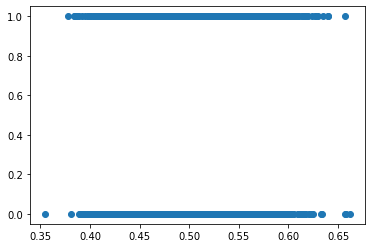

In [14]:
import matplotlib.pyplot as plt
plt.scatter( np.mean(pred_all, axis=1), action_ans_vl)
plt.show()

# Resnet

In [13]:
THRESHOLD = 0.5
model_list =glob.glob('../models/public/*.pth')
model_list = [
    '../models/public/online_model0.pth',
 '../models/public/online_model1.pth',
    '../models/public/online_model2.pth',
     '../models/public/online_model3.pth',
 '../models/public/online_model4.pth',
 ]

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm0 = nn.BatchNorm1d(len(all_feat_cols))
        self.dropout0 = nn.Dropout(0.2)

        dropout_rate = 0.2
        hidden_size = 256
        self.dense1 = nn.Linear(len(all_feat_cols), hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.dense2 = nn.Linear(hidden_size+len(all_feat_cols), hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.dense3 = nn.Linear(hidden_size+hidden_size, hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.dense4 = nn.Linear(hidden_size+hidden_size, hidden_size)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.dense5 = nn.Linear(hidden_size+hidden_size, len(target_cols))

        self.Relu = nn.ReLU(inplace=True)
        self.PReLU = nn.PReLU()
        self.LeakyReLU = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        # self.GeLU = nn.GELU()
        self.RReLU = nn.RReLU()

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.dropout0(x)

        x1 = self.dense1(x)
        x1 = self.batch_norm1(x1)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x1 = self.LeakyReLU(x1)
        x1 = self.dropout1(x1)

        x = torch.cat([x, x1], 1)

        x2 = self.dense2(x)
        x2 = self.batch_norm2(x2)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x2 = self.LeakyReLU(x2)
        x2 = self.dropout2(x2)

        x = torch.cat([x1, x2], 1)

        x3 = self.dense3(x)
        x3 = self.batch_norm3(x3)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x3 = self.LeakyReLU(x3)
        x3 = self.dropout3(x3)

        x = torch.cat([x2, x3], 1)

        x4 = self.dense4(x)
        x4 = self.batch_norm4(x4)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x4 = self.LeakyReLU(x4)
        x4 = self.dropout4(x4)

        x = torch.cat([x3, x4], 1)

        x = self.dense5(x)

        return x

In [6]:
print('Loading...')
train = pd.read_parquet(f'{INPUTPATH}/train.parquet')
features = [c for c in train.columns if 'feature' in c]

print('Filling...')
f_mean = train[features[1:]].mean()
train = train.loc[train.weight > 0].reset_index(drop = True)
train[features[1:]] = train[features[1:]].fillna(f_mean)
# train['action'] = (train['resp'] > 0).astype('int')


print('Converting...')
# train = train.to_pandas()
f_mean = f_mean.values#.get()
# np.save('f_mean.npy', f_mean)

x_tt = train.loc[:, features].values
train['features_41_42_43'] = x_tt[:, 41] + x_tt[:, 42] + x_tt[:, 43]
train['features_1_2'] = x_tt[:, 1] / (x_tt[:, 2] + 1e-5)
features = [c for c in train.columns if 'feature' in c]
all_feat_cols = features #[col for col in feat_cols]


date = train.date.values
weight = train.weight.values
resp = train.resp.values
X = train[features].values
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']
y = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T


print('Finish.')



Loading...
Filling...
Converting...
Finish.


In [12]:
X.shape

(1571415, 132)

In [9]:
target_cols = resp_cols.copy()

In [10]:
model = Model()
model.to(DEVICE)

Model(
  (batch_norm0): BatchNorm1d(132, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout0): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=132, out_features=256, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=388, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense3): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (dense4): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (dense5): Linear(in_f

In [29]:
gkf =  PurgedGroupTimeSeriesSplit(n_splits = FOLDS,  group_gap = GROUP_GAP)
for fold, (tr, vl) in enumerate(gkf.split(y,y, date)):
    X_tr, X_val = X[tr], X[vl]
    y_tr, y_val = y[tr], y[vl]
    trn_dat = CustomDataset(X_tr, y_tr)
    val_dat = CustomDataset(X_val, y_val)
    trn_loader = DataLoader(trn_dat , batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dat , batch_size=BATCH_SIZE, shuffle=False)

    preds = []   

    for i, data in tqdm(enumerate(val_loader)):
        x = data['x'].to(DEVICE)
        outputs = np.zeros((len(x), y.shape[1]))
        with torch.no_grad():
            for mdl in model_list:
                model.load_state_dict(torch.load(mdl))
                model.eval()
                
                outputs += model(x).sigmoid().detach().cpu().numpy()/len(model_list)
                print(outputs.shape)
            preds.append(outputs)

    pred_all  = np.concatenate(preds)

#             action = np.where(pred_all[:,0] >= THRESHOLD, 1, 0).astype(int).copy()
    action = np.where(np.mean(pred_all, axis=1)> THRESHOLD, 1, 0).astype(int).copy()
    if np.sum(action)>0:
        date_vl = date[vl].copy()
        weight_vl = weight[vl].copy()
        resp_vl = resp[vl].copy()
        action_ans_vl = np.where(y[vl,0]> THRESHOLD, 1, 0).astype(int).copy()
        cv_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action)
        max_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action_ans_vl )
        print('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
#         logger.info('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
    else:
        raise ZeroDivisionError

|          | 0/? [00:00<?, ?it/s]

(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)
(16384, 5)


ValueError: operands could not be broadcast together with shapes (7828,5) (7168,5) (7828,5) 

# Transformer

In [4]:
DATAVER = '05'
# SERIES= 1024
f_mean = np.load( f'{INPUTPATH}/f_mean_{DATAVER}.npy')
X = np.load( f'{INPUTPATH}/X_{DATAVER}.npy')
y = np.load( f'{INPUTPATH}/y_{DATAVER}.npy')
date = np.load( f'{INPUTPATH}/date_{DATAVER}.npy')
weight = np.load( f'{INPUTPATH}/weight_{DATAVER}.npy' )
resp = np.load( f'{INPUTPATH}/resp_{DATAVER}.npy')

In [6]:
THRESHOLD = 0.5
model_list =glob.glob('../models/transformer_cv_base_003/*.pth')
model_list

['../models/transformer_cv_base_003/transformer_fold_2_35.pth',
 '../models/transformer_cv_base_003/transformer_fold_1_5.pth',
 '../models/transformer_cv_base_003/transformer_fold_3_6.pth',
 '../models/transformer_cv_base_003/transformer_fold_4_8.pth',
 '../models/transformer_cv_base_003/transformer_fold_5_7.pth']

In [7]:
model_list = [
 '../models/transformer_cv_base_003/transformer_fold_1_5.pth',
'../models/transformer_cv_base_003/transformer_fold_2_35.pth',
 '../models/transformer_cv_base_003/transformer_fold_3_6.pth',
 '../models/transformer_cv_base_003/transformer_fold_4_8.pth',
 '../models/transformer_cv_base_003/transformer_fold_5_7.pth'
             ]

In [8]:
model = TransformerModel(input_size = X.shape[-1], output_size = y.shape[-1], batch_size = BATCH_SIZE).to(DEVICE)
model.to(DEVICE)

TransformerModel(
  (dropout1): Dropout(p=0.1, inplace=False)
  (layer0): Sequential(
    (0): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=160, out_features=512, bias=True)
    (2): Swish_module()
  )
  (layer1): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layer2): Linear(in_features=512, out_features=5

In [11]:
X_val.shape

(312613, 160)

In [10]:
gkf =  PurgedGroupTimeSeriesSplit(n_splits = FOLDS,  group_gap = GROUP_GAP)
for fold, (tr, vl) in enumerate(gkf.split(y,y, date)):
    X_tr, X_val = X[tr], X[vl]
    y_tr, y_val = y[tr], y[vl]
    trn_dat = CustomDataset(X_tr, y_tr)
    val_dat = CustomDataset(X_val, y_val)
    trn_loader = DataLoader(trn_dat , batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dat , batch_size=BATCH_SIZE, shuffle=False)

    preds = []   

    for i, data in tqdm(enumerate(val_loader)):
        x = data['x'].to(DEVICE)
        outputs = np.zeros((len(x), y.shape[1]))
        with torch.no_grad():
            for mdl in model_list:
                model.load_state_dict(torch.load(mdl))
                model.eval()
                if len(x) != len(model(x)):
                    x = x[:len(model(x))].clone()
                outputs += model(x).sigmoid().detach().cpu().numpy()/len(model_list)
                
            preds.append(outputs)

    pred_all  = np.concatenate(preds)

    action = np.where(np.mean(pred_all, axis=1)> THRESHOLD, 1, 0).astype(int).copy()
    if np.sum(action)>0:
        date_vl = date[vl].copy()
        weight_vl = weight[vl].copy()
        resp_vl = resp[vl].copy()
        action_ans_vl = np.where(y[vl,0]> THRESHOLD, 1, 0).astype(int).copy()
        cv_score = utility_score_bincount(date_vl[:action.shape[0]]  , weight_vl[:action.shape[0]], resp_vl[:action.shape[0]]  , action)
        max_score = utility_score_bincount(date_vl , weight_vl , resp_vl , action_ans_vl )
        print('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
#         logger.info('CV score is {}, Max score is {}, return ratio is {:.1f} '.format(cv_score, max_score, 100*(cv_score/max_score)))
    else:
        raise ZeroDivisionError

|          | 0/? [00:00<?, ?it/s]

CV score is 3223.485028294815, Max score is 10786.33238504988, return ratio is 29.9 


|          | 0/? [00:00<?, ?it/s]

CV score is 620.4919984921067, Max score is 14589.539114302985, return ratio is 4.3 


|          | 0/? [00:00<?, ?it/s]

CV score is 1061.0141499154147, Max score is 13972.055056022891, return ratio is 7.6 


|          | 0/? [00:00<?, ?it/s]

CV score is 199.75335967892272, Max score is 13014.211417401355, return ratio is 1.5 


|          | 0/? [00:00<?, ?it/s]

CV score is 1479.8201565792601, Max score is 14679.813965730122, return ratio is 10.1 


In [47]:
model.load_state_dict(torch.load(model_list[1]))
len(model(x))

7168

In [40]:
model(x[:len(model(x))]).shape

torch.Size([7168, 5])

In [65]:
 m = nn.Conv1d(160, 512, 1, stride=2)
input = torch.randn(20, 160).unsqueeze(2)
output = m(input)

In [67]:
input.shape

torch.Size([20, 160, 1])

In [68]:
m(input).shape

torch.Size([20, 512, 1])

In [71]:
output.permute(2,0,1).squeeze().shape

torch.Size([20, 512])

# Predict Test 

In [3]:
print(f'{MDL_PATH}/{MDL_NAME}_{VER}')

../models/ae_cv_base


In [ ]:
#!kaggle datasets init -p ../models/autoencoder_test

In [9]:
%%writefile ../models/ae_cv_base/dataset-metadata.json
{
    "title": "Jane-Street",
    "id": "shinsei66/Jane-Street",
    "subtitle": "",
    "description": "",
    "isPrivate": true,
    "licenses": [
        {
            "name": "unknown" 
        }
    ],
    "keywords": [],
    "collaborators": [],
    "data": [
        {
            "description": null,
            "name": "autoencoder_99.pth",
            "totalBytes": 848,
            "columns": []
        },
        {
            "description": null,
            "name": "autoencoder_254.pth",
            "totalBytes": 856,
            "columns": []
        },
        {
            "description": null,
            "name": "mlp_base_984.pth",
            "totalBytes": 1316,
            "columns": []
        },
         {
            "description": null,
            "name": "ae_fold_1_18.pth",
            "totalBytes": 840,
            "columns": []
        },
        {
            "description": null,
            "name": "ae_fold_2_428.pth",
            "totalBytes": 840,
            "columns": []
        },
        {
            "description": null,
            "name": "ae_fold_3_500.pth",
            "totalBytes": 840,
            "columns": []
        },
        {
            "description": null,
            "name": "ae_fold_4_199.pth",
            "totalBytes": 840,
            "columns": []
        },
        {
            "description": null,
            "name": "ae_fold_5_497.pth",
            "totalBytes": 840,
            "columns": []
        }
    ]
}

Writing ../models/ae_cv_base/dataset-metadata.json


In [ ]:
#!kaggle datasets create -p  ../models/autoencoder_early_stopping

In [7]:
!du ../models/ae_cv_base/ -a

840	../models/ae_cv_base/ae_fold_5_497.pth
76	../models/ae_cv_base/ae_learning_history.csv
840	../models/ae_cv_base/ae_fold_2_428.pth
4	../models/ae_cv_base/.ipynb_checkpoints
840	../models/ae_cv_base/ae_fold_3_500.pth
840	../models/ae_cv_base/ae_fold_4_199.pth
840	../models/ae_cv_base/ae_fold_1_18.pth
4284	../models/ae_cv_base/


In [10]:
!kaggle datasets version -p  ../models/ae_cv_base -m "auto encoder 5 fold cv baseline"

Starting upload for file ae_fold_5_497.pth
100%|████████████████████████████████████████| 836k/836k [08:47<00:00, 1.62kB/s]
Upload successful: ae_fold_5_497.pth (836KB)
Starting upload for file ae_learning_history.csv
100%|████████████████████████████████████████| 73.9k/73.9k [08:46<00:00, 144B/s]
Upload successful: ae_learning_history.csv (74KB)
Starting upload for file ae_fold_2_428.pth
100%|████████████████████████████████████████| 836k/836k [08:47<00:00, 1.62kB/s]
Upload successful: ae_fold_2_428.pth (836KB)
Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file ae_fold_3_500.pth
100%|████████████████████████████████████████| 836k/836k [08:46<00:00, 1.63kB/s]
Upload successful: ae_fold_3_500.pth (836KB)
Starting upload for file ae_fold_4_199.pth
100%|████████████████████████████████████████| 836k/836k [08:45<00:00, 1.63kB/s]
Upload successful: ae_fold_4_199.pth (836KB)
Starting upload for file ae_fold_1_18.pth
100%|█████████████████████████